In [1]:
# Cell 1 - imports / config / helpers
import os
import cv2
import joblib
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- CONFIG ----------------
OFFICIAL_DIR   = r"D:\Infosys_AI-Tracefinder\Data\Official"
FLATFIELD_DIR  = r"D:\Infosys_AI-Tracefinder\Data\Flatfield"
WIKI_DIR       = r"D:\Infosys_AI-Tracefinder\Data\Wikipedia"

OUTPUT_DIR       = r"D:\Infosys_AI-Tracefinder\Output"
OUTPUT_MODELS    = r"D:\Infosys_AI-Tracefinder\Notebooks"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_MODELS, exist_ok=True)

FEATURE_COLUMNS = [
    "file_name", "class_label", "resolution_level",
    "width", "height", "aspect_ratio", "file_size_kb",
    "mean_intensity", "std_intensity",
    "skewness", "kurtosis", "entropy", "edge_density"
]

# ---------------- HELPERS ----------------
def safe_listdir(p):
    try:
        return os.listdir(p)
    except Exception:
        return []

def compute_basic_features(img_path):
    """
    Read TIFF (preserve original), compute basic features used by sklearn pipeline.
    Raises on failure so caller can log skipped file + reason.
    """
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError("cv2.imread returned None (cannot read).")

    # convert to grayscale if multi-channel
    if img.ndim == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img.copy()

    h, w = img_gray.shape[:2]
    aspect_ratio = float(w) / float(h) if h != 0 else 0.0
    file_size_kb = float(os.path.getsize(img_path)) / 1024.0

    imgf = img_gray.astype(np.float32)
    maxv = float(imgf.max()) if imgf.max() > 0 else 1.0
    imgn = imgf / maxv

    mean_intensity = float(imgn.mean())
    std_intensity = float(imgn.std())

    flat = imgn.flatten()
    skewness = float(skew(flat)) if flat.size > 0 else 0.0
    kurt = float(kurtosis(flat)) if flat.size > 0 else 0.0

    hist, _ = np.histogram(flat, bins=256, range=(0.0, 1.0), density=True)
    hist = hist + 1e-12
    entropy = float(-np.sum(hist * np.log2(hist)))

    edges = cv2.Canny((imgn * 255).astype(np.uint8), 100, 200)
    edge_density = float(edges.astype(bool).sum()) / (w * h) if (w*h) > 0 else 0.0

    return {
        "width": int(w),
        "height": int(h),
        "aspect_ratio": aspect_ratio,
        "file_size_kb": file_size_kb,
        "mean_intensity": mean_intensity,
        "std_intensity": std_intensity,
        "skewness": skewness,
        "kurtosis": kurt,
        "entropy": entropy,
        "edge_density": edge_density
    }


In [2]:
# Cell 2 - scanner function (handles both structures)
def scan_dataset_to_df(root_dir, dataset_name):
    """
    Scans:
     - scanner/dpi/*.tif  (official, wikipedia)
     - scanner/*.tif      (flatfield)
    Returns DataFrame and a report dict (total_found, processed, skipped list)
    """
    rows = []
    skipped = []
    total_found = 0
    processed = 0
    tiff_exts = (".tif", ".tiff")

    scanners = [d for d in safe_listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    print(f"\nScanning dataset '{dataset_name}' at: {root_dir}  (scanners: {len(scanners)})")

    for scanner in scanners:
        scanner_path = os.path.join(root_dir, scanner)
        subdirs = [d for d in safe_listdir(scanner_path) if os.path.isdir(os.path.join(scanner_path, d))]

        if subdirs:
            # CASE A: scanner/dpi/file.tif
            for dpi in subdirs:
                dpi_path = os.path.join(scanner_path, dpi)
                files = [f for f in safe_listdir(dpi_path) if f.lower().endswith(tiff_exts) and not f.startswith("._")]
                total_found += len(files)
                for f in tqdm(files, desc=f"{dataset_name}:{scanner}/{dpi}", leave=False):
                    fpath = os.path.join(dpi_path, f)
                    try:
                        feats = compute_basic_features(fpath)
                        processed += 1
                        rows.append({
                            "file_name": f,
                            "class_label": scanner,
                            "resolution_level": int(dpi) if str(dpi).isdigit() else 0,
                            **feats
                        })
                    except Exception as e:
                        skipped.append((fpath, str(e)))
        else:
            # CASE B: scanner/file.tif (flatfield)
            files = [f for f in safe_listdir(scanner_path) if f.lower().endswith(tiff_exts) and not f.startswith("._")]
            total_found += len(files)
            for f in tqdm(files, desc=f"{dataset_name}:{scanner}", leave=False):
                fpath = os.path.join(scanner_path, f)
                try:
                    try:
                        dpi = int(os.path.splitext(f)[0])
                    except:
                        dpi = 0
                    feats = compute_basic_features(fpath)
                    processed += 1
                    rows.append({
                        "file_name": f,
                        "class_label": scanner,
                        "resolution_level": dpi,
                        **feats
                    })
                except Exception as e:
                    skipped.append((fpath, str(e)))

    df = pd.DataFrame(rows, columns=FEATURE_COLUMNS)
    report = {"total_found": total_found, "processed": processed, "skipped": skipped, "rows": len(df)}
    print(f"📌 Total TIFFs found: {total_found}")
    print(f"📌 Successfully processed: {processed}")
    print(f"⚠️ Skipped: {len(skipped)}")
    return df, report


In [3]:
# Cell 3 - run scanning and save per-dataset CSVs
datasets = [
    ("Official", OFFICIAL_DIR),
    ("Flatfield", FLATFIELD_DIR),
    ("Wikipedia", WIKI_DIR)
]

df_list = []
reports = {}

for name, folder in datasets:
    if not folder or not os.path.exists(folder):
        print(f"❌ Skipping missing dataset: {name} -> {folder}")
        continue
    df_ds, report = scan_dataset_to_df(folder, name)
    csv_path = os.path.join(OUTPUT_DIR, f"Output_for_{name}.csv")
    df_ds.to_csv(csv_path, index=False)
    print(f"💾 Saved CSV: {csv_path}  (rows={len(df_ds)})")
    df_list.append(df_ds)
    reports[name] = report

if len(df_list) == 0:
    raise RuntimeError("No datasets scanned. Check dataset paths.")



Scanning dataset 'Official' at: D:\Infosys_AI-Tracefinder\Data\Official  (scanners: 11)


📌 Total TIFFs found: 2200
📌 Successfully processed: 2200
⚠️ Skipped: 0
💾 Saved CSV: D:\Infosys_AI-Tracefinder\Output\Output_for_Official.csv  (rows=2200)

Scanning dataset 'Flatfield' at: D:\Infosys_AI-Tracefinder\Data\Flatfield  (scanners: 11)


📌 Total TIFFs found: 22
📌 Successfully processed: 22
⚠️ Skipped: 0
💾 Saved CSV: D:\Infosys_AI-Tracefinder\Output\Output_for_Flatfield.csv  (rows=22)

Scanning dataset 'Wikipedia' at: D:\Infosys_AI-Tracefinder\Data\Wikipedia  (scanners: 11)


📌 Total TIFFs found: 2367
📌 Successfully processed: 2367
⚠️ Skipped: 0
💾 Saved CSV: D:\Infosys_AI-Tracefinder\Output\Output_for_Wikipedia.csv  (rows=2367)


In [4]:
# Cell 4 - combine and sanity-check
df_all = pd.concat(df_list, ignore_index=True)
combined_csv = os.path.join(OUTPUT_DIR, "Output_for_Allfiles.csv")
df_all.to_csv(combined_csv, index=False)
print(f"\n🔥 Combined dataset saved: {combined_csv}  (rows={len(df_all)})")

# Quick sanity: ensure expected columns exist
missing = [c for c in FEATURE_COLUMNS if c not in df_all.columns]
if missing:
    raise RuntimeError("Combined CSV missing expected columns: " + str(missing))
else:
    print("All expected feature columns present.")



🔥 Combined dataset saved: D:\Infosys_AI-Tracefinder\Output\Output_for_Allfiles.csv  (rows=4589)
All expected feature columns present.


In [5]:
# Cell 5 - prepare data and train models
df = df_all.dropna(subset=FEATURE_COLUMNS)
print("Rows after dropping NaNs:", len(df))

le = LabelEncoder()
df["class_label_encoded"] = le.fit_transform(df["class_label"])
print("Classes:", list(le.classes_))

# features: include resolution_level + the original features
X = df[FEATURE_COLUMNS[2:]]  # resolution_level first in this slice
y = df["class_label_encoded"]

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print("Train:", X_train_df.shape, " Test:", X_test_df.shape)

scaler = StandardScaler()
scaler.fit(X_train_df)
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)
print("Scaler fitted. n_features_in_ =", getattr(scaler, "n_features_in_", None))

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced")
}

results = {}
trained = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    trained[name] = model
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


Rows after dropping NaNs: 4589
Classes: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']
Train: (3671, 11)  Test: (918, 11)
Scaler fitted. n_features_in_ = 11

Training RandomForest ...
RandomForest Accuracy: 0.3976
              precision    recall  f1-score   support

  Canon120-1       0.06      0.06      0.06        83
  Canon120-2       0.22      0.20      0.21        83
    Canon220       0.55      0.57      0.56        84
 Canon9000-1       0.25      0.27      0.26        84
 Canon9000-2       0.17      0.15      0.16        82
 EpsonV370-1       0.34      0.32      0.33        84
 EpsonV370-2       0.35      0.36      0.36        83
  EpsonV39-1       0.23      0.25      0.24        84
  EpsonV39-2       0.20      0.19      0.20        84
   EpsonV550       1.00      1.00      1.00        83
          HP       1.00      0.99      0.99        84

    accuracy                       

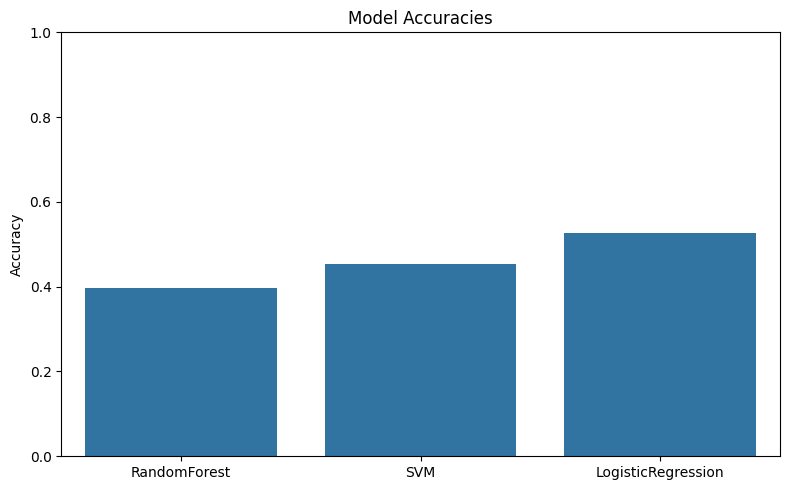


===== MODEL: RandomForest =====
              precision    recall  f1-score   support

  Canon120-1       0.06      0.06      0.06        83
  Canon120-2       0.22      0.20      0.21        83
    Canon220       0.55      0.57      0.56        84
 Canon9000-1       0.25      0.27      0.26        84
 Canon9000-2       0.17      0.15      0.16        82
 EpsonV370-1       0.34      0.32      0.33        84
 EpsonV370-2       0.35      0.36      0.36        83
  EpsonV39-1       0.23      0.25      0.24        84
  EpsonV39-2       0.20      0.19      0.20        84
   EpsonV550       1.00      1.00      1.00        83
          HP       1.00      0.99      0.99        84

    accuracy                           0.40       918
   macro avg       0.40      0.40      0.40       918
weighted avg       0.40      0.40      0.40       918



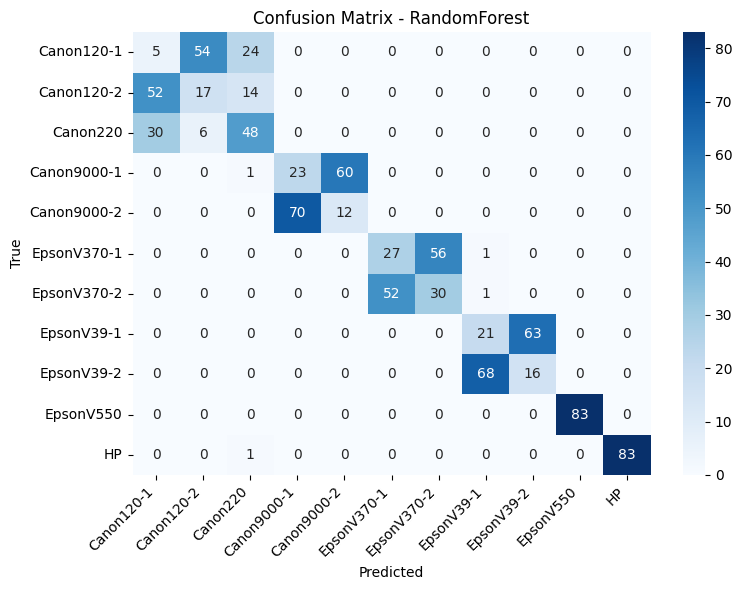


===== MODEL: SVM =====
              precision    recall  f1-score   support

  Canon120-1       0.23      0.13      0.17        83
  Canon120-2       0.29      0.40      0.33        83
    Canon220       0.34      0.40      0.37        84
 Canon9000-1       0.26      0.36      0.30        84
 Canon9000-2       0.22      0.17      0.19        82
 EpsonV370-1       0.53      0.64      0.58        84
 EpsonV370-2       0.54      0.49      0.52        83
  EpsonV39-1       0.23      0.20      0.22        84
  EpsonV39-2       0.38      0.26      0.31        84
   EpsonV550       0.94      0.93      0.93        83
          HP       1.00      0.99      0.99        84

    accuracy                           0.45       918
   macro avg       0.45      0.45      0.45       918
weighted avg       0.45      0.45      0.45       918



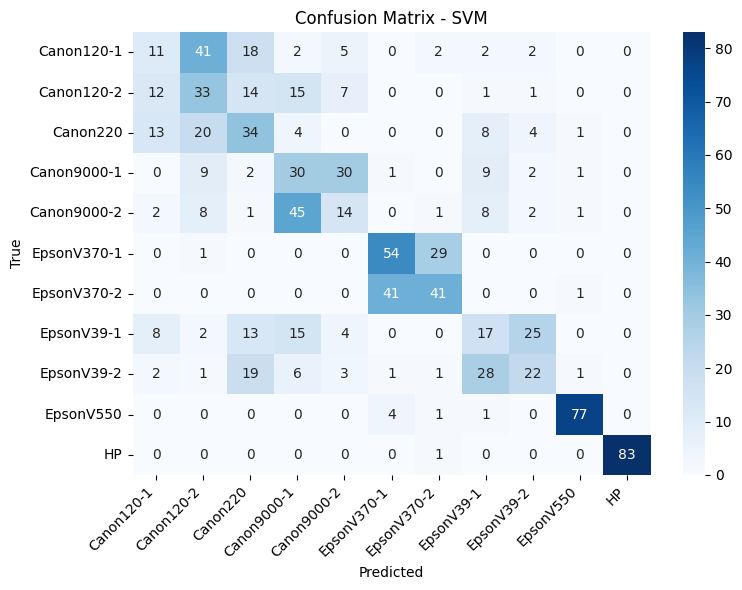


===== MODEL: LogisticRegression =====
              precision    recall  f1-score   support

  Canon120-1       0.41      0.29      0.34        83
  Canon120-2       0.43      0.55      0.48        83
    Canon220       0.38      0.54      0.44        84
 Canon9000-1       0.45      0.63      0.52        84
 Canon9000-2       0.28      0.18      0.22        82
 EpsonV370-1       0.59      0.80      0.68        84
 EpsonV370-2       0.53      0.40      0.46        83
  EpsonV39-1       0.38      0.29      0.33        84
  EpsonV39-2       0.50      0.35      0.41        84
   EpsonV550       0.80      0.77      0.79        83
          HP       0.99      1.00      0.99        84

    accuracy                           0.53       918
   macro avg       0.52      0.53      0.51       918
weighted avg       0.52      0.53      0.52       918



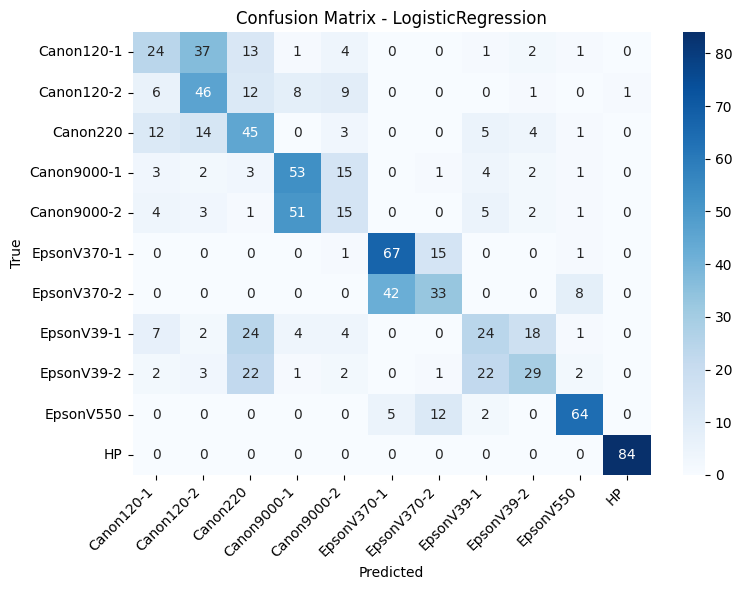


===== ENSEMBLE (majority vote) =====
Models used in ensemble: ['RandomForest', 'SVM', 'LogisticRegression']
              precision    recall  f1-score   support

  Canon120-1       0.13      0.13      0.13        83
  Canon120-2       0.32      0.41      0.36        83
    Canon220       0.39      0.50      0.44        84
 Canon9000-1       0.29      0.38      0.33        84
 Canon9000-2       0.16      0.10      0.12        82
 EpsonV370-1       0.51      0.68      0.58        84
 EpsonV370-2       0.55      0.40      0.46        83
  EpsonV39-1       0.30      0.25      0.27        84
  EpsonV39-2       0.38      0.25      0.30        84
   EpsonV550       0.94      0.93      0.93        83
          HP       1.00      0.99      0.99        84

    accuracy                           0.46       918
   macro avg       0.45      0.46      0.45       918
weighted avg       0.45      0.46      0.45       918



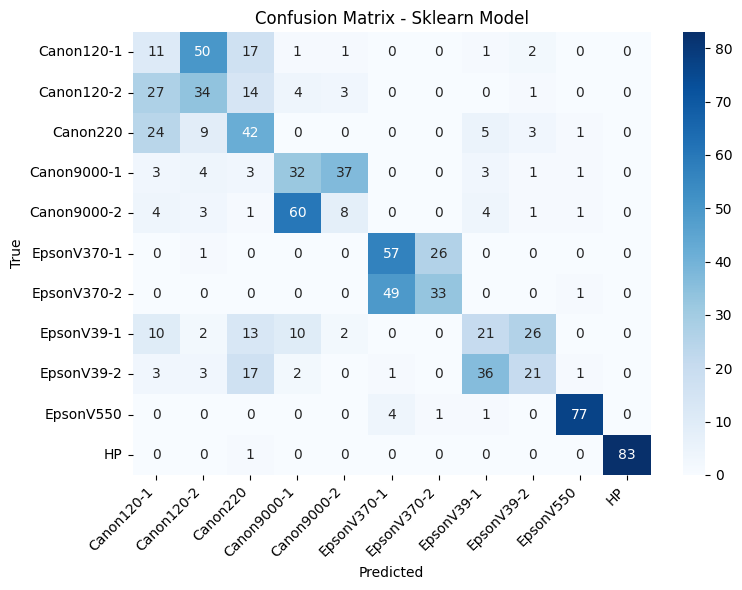


Saved artifacts. Best model: LogisticRegression


In [6]:
# Cell 6 (REPLACE previous Cell 6) - Per-model confusion matrices + accuracies + ensemble
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ---- 1) Bar chart of accuracies (same style you used earlier) ----
plt.figure(figsize=(8,5))
names = list(results.keys())
accs = [results[n] for n in names]
sns.barplot(x=names, y=accs)
plt.ylim(0,1)
plt.title("Model Accuracies")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_MODELS, "model_accuracies.png"))
plt.show()

# ---- 2) Confusion matrix + report for each model ----
for name, model in trained.items():
    print(f"\n===== MODEL: {name} =====")
    try:
        y_pred = model.predict(X_test)
    except Exception as e:
        print("Prediction failed for", name, "->", e)
        continue

    print(classification_report(y_test, y_pred, target_names=list(le.classes_)))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    fname = os.path.join(OUTPUT_MODELS, f"confusion_{name}.png")
    plt.savefig(fname)
    plt.show()

# ---- 3) Ensemble (majority vote) confusion matrix ----
# Collect predictions from available models
preds = []
model_names_for_ensemble = []
for name, model in trained.items():
    try:
        p = model.predict(X_test)
        preds.append(p.reshape(-1,1))
        model_names_for_ensemble.append(name)
    except Exception as e:
        print("Skipping", name, "in ensemble due to prediction error:", e)

if len(preds) == 0:
    print("No model predictions available for ensemble.")
else:
    preds_matrix = np.hstack(preds)   # shape (n_samples, n_models)
    # majority vote per sample
    ensemble_pred = []
    for row in preds_matrix:
        vals, counts = np.unique(row, return_counts=True)
        top_idx = np.argmax(counts)
        # if tie, prefer best_model's prediction
        if list(counts).count(counts[top_idx]) > 1 and 'best_name' in globals():
            # pick best_model's prediction if present in row
            best_idx_in_row = None
            try:
                best_idx = list(trained.keys()).index(best_name)
                ensemble_pred.append(int(row[best_idx]))
                continue
            except Exception:
                pass
        ensemble_pred.append(int(vals[top_idx]))
    ensemble_pred = np.array(ensemble_pred)

    print("\n===== ENSEMBLE (majority vote) =====")
    print("Models used in ensemble:", model_names_for_ensemble)
    print(classification_report(y_test, ensemble_pred, target_names=list(le.classes_)))
    cm = confusion_matrix(y_test, ensemble_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix - Sklearn Model")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    fname = os.path.join(OUTPUT_MODELS, "confusion_ensemble.png")
    plt.savefig(fname)
    plt.show()

# ---- 4) Save best model artifact (unchanged) ----
best_name = max(results, key=results.get)
best_model = trained[best_name]
joblib.dump(best_model, os.path.join(OUTPUT_MODELS, "best_model.pkl"))
joblib.dump(scaler, os.path.join(OUTPUT_MODELS, "scaler.pkl"))
joblib.dump(le, os.path.join(OUTPUT_MODELS, "label_encoder.pkl"))
joblib.dump({
    "feature_columns": list(X.columns),
    "n_features": X.shape[1],
    "classes": list(map(str, le.classes_)),
    "best_model": best_name
}, os.path.join(OUTPUT_MODELS, "sklearn_metadata.pkl"))

print("\nSaved artifacts. Best model:", best_name)


In [15]:
# --- Single-image prediction (robust DPI detection) ---
import os, re, joblib, pandas as pd, numpy as np

sample_img = r"D:\Infosys_AI-Tracefinder\Data\Flatfield\Canon9000-1\150.tif"

def detect_resolution(path):
    parent = os.path.basename(os.path.dirname(path))
    if parent.isdigit():
        return int(parent)
    fname = os.path.splitext(os.path.basename(path))[0]
    if fname.isdigit():
        return int(fname)
    grand = os.path.basename(os.path.dirname(os.path.dirname(path)))
    if grand.isdigit():
        return int(grand)
    m = re.search(r'(\d{2,4})', fname)
    return int(m.group(1)) if m else 0

# load artifacts (try common locations)
def try_load(name):
    for p in (name, os.path.join(OUTPUT_MODELS, name) if 'OUTPUT_MODELS' in globals() else None,
              os.path.join(OUTPUT_DIR, name) if 'OUTPUT_DIR' in globals() else None):
        if not p: 
            continue
        try:
            return joblib.load(p)
        except Exception:
            pass
    raise FileNotFoundError(f"Could not load {name}")

model  = try_load("best_model.pkl")
scaler = try_load("scaler.pkl")
le     = try_load("label_encoder.pkl")

# build feature row
feats = compute_basic_features(sample_img)    # already in your notebook
res = detect_resolution(sample_img)
X_single = pd.DataFrame([{"resolution_level": int(res), **feats}])

# ensure same column ordering as training
try:
    cols_order = list(X.columns)   # X from training cell
except Exception:
    cols_order = FEATURE_COLUMNS[2:]  # fallback
X_single = X_single[cols_order]

# scale + predict
Xs = scaler.transform(X_single)
pred = model.predict(Xs)[0]
try:
    conf = float(model.predict_proba(Xs)[0].max())
except Exception:
    conf = 1.0

print("Prediction:", le.inverse_transform([pred])[0])
print("Confidence:", conf)


Prediction: Canon9000-2
Confidence: 0.5809981919517769
